In [1]:
# modify and uncomment to update the model and its parameters
# !cp /ptmp/nbudanur/KS/public/po1/ctrans_3.60e+00/lightning_logs/version_2/checkpoints/epoch=39-step=1049600.ckpt ../models/conjnet_po_1.ckpt
# !cp /ptmp/nbudanur/KS/public/po1/ctrans_3.60e+00/parameters.txt ../models/parameters_po1.txt
# !cp /ptmp/nbudanur/KS/public/po3exp2/ctrans_3.60e+00/lightning_logs/version_2/checkpoints/epoch=39-step=1395520.ckpt ../models/conjnet_po_3.ckpt
# !cp /ptmp/nbudanur/KS/public/po3exp2/ctrans_3.60e+00/parameters.txt ../models/parameters_po3.txt

In [2]:
import numpy as np
from pathlib import Path
import h5py
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from numpy.linalg import norm
import torch
import sys
sys.path.append('../')
from KS import KS
sys.path.append('../training/')
import diagnostics

plt.rcParams.update({
    "text.usetex": True,
    "font.size": '16',
})

In [3]:
color_palette = sns.color_palette("colorblind")

In [4]:
ks = KS(L=22.0, K=15, dt=0.01)

In [5]:
pdata = Path('../data/trajectory.hdf5')
ppos = Path('../data/5POs_L22.000.hdf5')

try:
    fdata = h5py.File(pdata, 'r')
    sol = fdata["sol"][:, :]
    sol_ = fdata['sol_'][:, :]
    tt_sol = fdata["tt"][()]
    fdata.close()
except:
    # random trajectory
    np.random.seed(42)
    ic = ks.flow(np.random.randn(ks.d) * 0.01, 100)
    tt_sol = np.arange(0, 1000, 0.01)
    sol = odeint(ks.rhs, ic, tt_sol)
    sol_ = ks.symmreduce(sol)

    fdata = h5py.File(pdata, 'w')

    # gsol = fdata.create_group('sol')
    fdata['sol'] = sol
    fdata['sol_'] = sol_
    fdata['tt'] = tt_sol
    fdata.close()

fpos = h5py.File(ppos, 'r')
pos = {}

for ipo, po in enumerate(fpos.keys()):

    pos[po] = {}
    for key in fpos[po].keys():
        pos[po][key] = fpos[po][key][()]
    
    xi_p = pos[po]['xi_p']
    T_p = pos[po]['T_p']
    tt = np.arange(0, T_p, 0.01)
    
    if pos[po]['translation'] and pos[po]['reflection']:
        xi_p = ks.SO2_operator(- pos[po]['phi_p'] / 2) @ xi_p
    
    sol_po = odeint(ks.rhs, xi_p, tt)
    red_sol_po = ks.symmreduce(sol_po)
    pos[po]['sol'] = sol_po
    pos[po]['red_sol'] = red_sol_po

fpos.close()

no kom parameter found, setting kom=0
no kom parameter found, setting kom=0


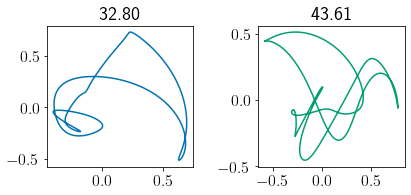

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

for iax, ipo in enumerate([0, 2]):

    po = list(pos.keys())[ipo]
    ax = axes[iax]

    xi_p = pos[po]['xi_p']
    T_p = pos[po]['T_p']

    tt = np.arange(0, T_p, ks.dt)
    sol_po = odeint(ks.rhs, xi_p, tt)
    sol_po_ = ks.symmreduce(sol_po)
    pca = PCA(n_components=3).fit(sol_po_)
    po_pca = pca.transform(sol_po_)

    pos[po]['pca'] = pca
    pos[po]['po_pca'] = po_pca
    ax.plot(po_pca[:, 0], po_pca[:, 1], color=color_palette[ipo])
    ax.set_title(f"{T_p:2.2f}")

    J_p = pos[po]['J_p']

    LA_p, PS_p = np.linalg.eig(J_p)

    i_sort = np.argsort(np.abs(LA_p))[::-1]
    LA_p = LA_p[i_sort]
    PS_p = PS_p[:, i_sort]

    mu = np.log(np.abs(LA_p[0])) / T_p 

    if np.imag(LA_p[0]) == 0 and np.real(LA_p[0]) < 0:
        # non-orientable neighborhood
        om = np.abs(np.angle(LA_p[0])) / T_p

        i_mu_s = np.argwhere(np.abs(LA_p) - 1 < -1e-3).reshape(-1)[0]
        mu_s = np.log(np.real(np.abs(LA_p[i_mu_s]))) / T_p 
    elif not(np.angle(LA_p[0]) == 0):
        # spiraling neighborhood
        om = np.abs(np.angle(LA_p[0])) / T_p
        mu_s = 0
    else:
        # expanding/contracting neighborhood
        om = 0
        i_mu_s = np.argwhere(np.abs(LA_p) - 1 < -1e-3).reshape(-1)[0]
        mu_s = np.log(np.real(np.abs(LA_p[i_mu_s]))) / T_p 

    pars = diagnostics.read_parameters(f"../models/parameters_po{ipo+1}.txt")
    conjnet = diagnostics.get_conjnet(pars, ckpt=f"../models/conjnet_po_{ipo+1}.ckpt")
    pos[po]["conjnet"] = conjnet

fig.tight_layout()

# one-period predictions:

alpha_th condition not met at n = 1319
picking the smoothest alternative...
alpha_th condition not met at n = 2470
picking the smoothest alternative...
alpha_th condition not met at n = 2471
picking the smoothest alternative...
alpha_th condition not met at n = 2472
picking the smoothest alternative...
alpha_th condition not met at n = 3801
picking the smoothest alternative...


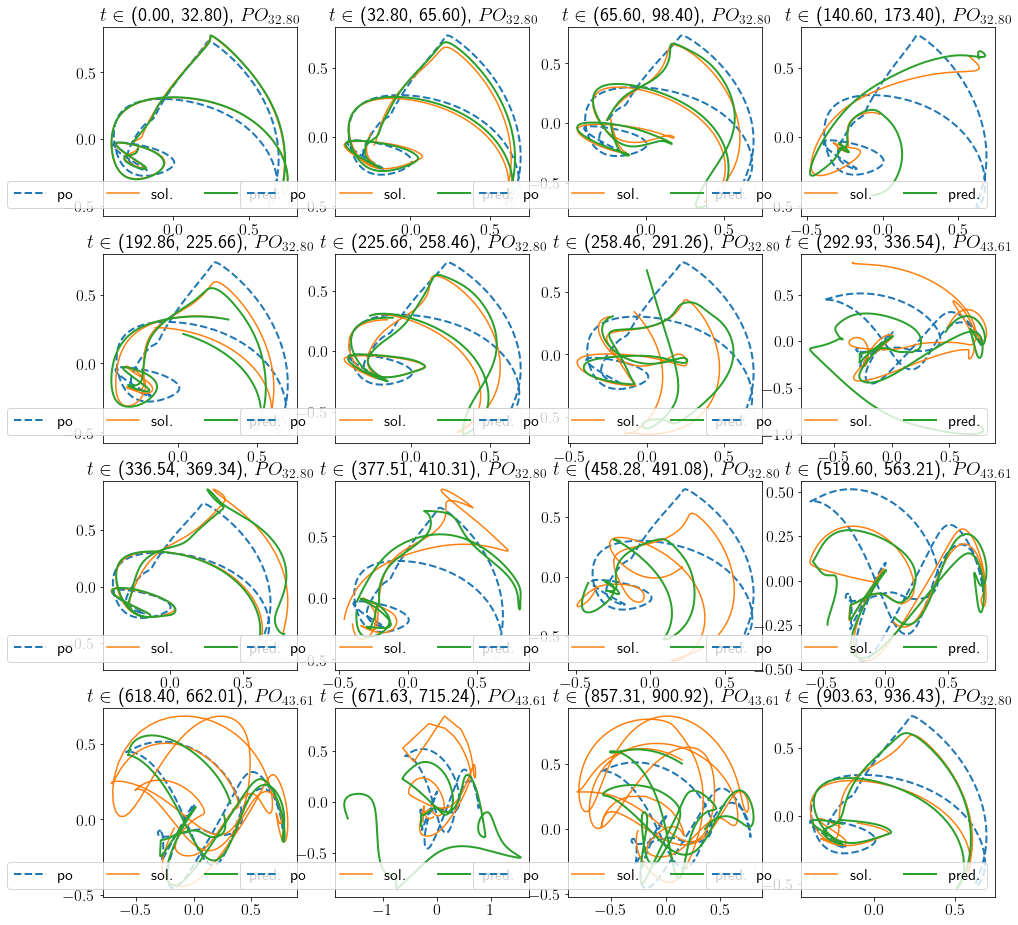

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

ep_ae = 0.1

episode = 0
it = 0 
sol_rec = np.zeros(sol.shape)
sol_pred_ = np.zeros(sol_.shape)
latent_sol = np.zeros((sol.shape[0], 3))
latent_pred = np.zeros((sol.shape[0], 3))

it_episodes = []


while episode < 16 and it<sol_.shape[0]:
    xi_test = sol_[it, :]
    indata = torch.tensor(xi_test).double()

    ae_pass = False
    min_relerr_ae = 1e99
    
    for ipo in [0, 2]:
    
        po = list(pos.keys())[ipo]
        conjnet = pos[po]['conjnet']
        xi_test_ae =  conjnet.decoder(
            conjnet.encoder(indata)
            ).detach().cpu().numpy()
        relerr_ae = norm(xi_test_ae - xi_test) / norm(xi_test)

        if relerr_ae < ep_ae and sol_.shape[0] - it > int(pos[po]['T_p'] / ks.dt):
            ae_pass = True
            if relerr_ae < min_relerr_ae:
                min_relerr_ae = float(relerr_ae)
                po_min_relerr = po

    if ae_pass: 
        po = po_min_relerr
        T_p = pos[po]['T_p']
        pca = pos[po]['pca']
        po_pca = pos[po]['po_pca']
        conjnet = pos[po]['conjnet']

        tt_pred = np.arange(0, T_p, ks.dt)
        sol_test = sol_[it:it+len(tt_pred), :]
          
        torch_sol_test_ = torch.tensor(sol_test)
        latent_sol[it:it+len(tt_pred), :] = conjnet.encoder(torch_sol_test_).detach().numpy()
        
        sol_test_pca = pca.transform(sol_test)

        indata = torch.tensor(
            np.insert(np.ones(sol_test.shape) * xi_test, 0, tt_pred, axis=1)
            )

        prediction = conjnet(indata.double())
        sol_pred = prediction.detach().cpu().numpy()
        sol_pred_pca = pca.transform(sol_pred)

        sol_pred_[it:it+len(tt_pred), :] = sol_pred.copy()
        sol_rec[it:it+len(tt_pred), :] = ks.reconst_sol(
            np.float64(sol_pred), tt_pred, xi_0=sol[it, :], alpha_th=0.95
        )

        latent_pred[it:it+len(tt_pred), :] = conjnet.et_t.detach().numpy()
        
        it_episodes.append([it, it+len(tt_pred)])        

        ax = axes.reshape(-1)[episode]
        ax.plot(po_pca[:, 0], po_pca[:, 1], '--', lw=2.0, label=f'po')
        ax.plot(sol_test_pca[:, 0], sol_test_pca[:, 1], '-', lw=1.5, label='sol.')
        ax.plot(sol_pred_pca[:, 0], sol_pred_pca[:, 1], '-', lw=2.0, label='pred.')
        ax.legend(ncol=3, loc=4)
        # ax.set_xlim(-0.65,0.65)
        # ax.set_ylim(-0.45,0.45)
        ax.set_title(
            f"$t \in $ ({it * ks.dt:2.2f}, {(it * ks.dt + T_p):2.2f})"
            f", $PO_{{{po}}}$"
            )
        episode += 1 
        it += len(tt_pred)
    else:
        it += 1

Text(0, 0.5, '')

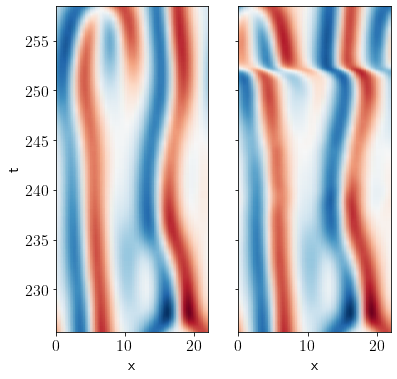

In [8]:
fig, axes = plt.subplots(1,2,figsize=(6,6),sharey=True)

i_episode=5

ni = it_episodes[i_episode][0]
nf = it_episodes[i_episode][1]
nskip = 1

# tt_sol = tt_pred.copy()
tt_plot = tt_sol[ni:nf:nskip]

ks.plot_spacetime(sol[ni:nf:nskip,:], tt_plot, ax = axes[0])
ks.plot_spacetime(sol_rec[ni:nf:nskip,:], tt_plot, ax = axes[1])
axes[1].set_ylabel('')

Text(0, 0.5, '')

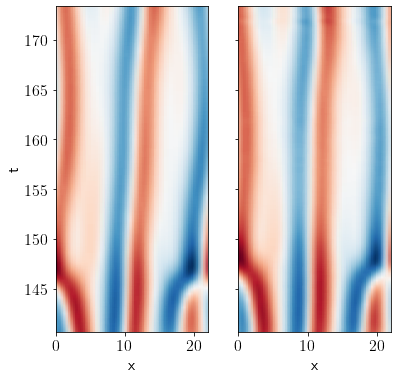

In [9]:
fig, axes = plt.subplots(1,2,figsize=(6,6),sharey=True)

T_p = pos['43.61']['T_p']
tt_pred = np.arange(0, T_p, ks.dt)


i_episode=3
ni = it_episodes[i_episode][0]
nf = it_episodes[i_episode][1]
nskip = 1

# tt_sol = tt_pred.copy()
tt_plot = tt_sol[ni:nf:nskip]

ks.plot_spacetime(sol[ni:nf:nskip,:], tt_plot, ax = axes[0])
ks.plot_spacetime(sol_rec[ni:nf:nskip,:], tt_plot, ax = axes[1])
axes[1].set_ylabel('')

In [10]:
# Errors:

error = norm(sol - sol_rec, axis=1) / norm(sol, axis=1)
error_ = norm(sol_ - sol_pred_, axis=1) / norm(sol_, axis=1)

input_sol = ks.power_in(sol)
input_pred = ks.power_in(sol_rec)

error_I = np.abs(input_sol - input_pred )/ input_sol

dissip_sol = ks.dissipation(sol)
dissip_pred = ks.dissipation(sol_rec)

error_D = np.abs(dissip_sol - dissip_pred) / dissip_sol

In [11]:
from matplotlib.patches import Rectangle

def add_rectangle(ax, t_i, t_f, y_i = 1e-8, y_f = 1e3):
    rectangle = Rectangle((t_i, y_i), width=t_f - t_i, height=y_f - y_i, fc='gray', alpha=0.1)
    ax.add_artist(rectangle)

292.93 336.54
519.6 563.21
292.93 336.54
519.6 563.21


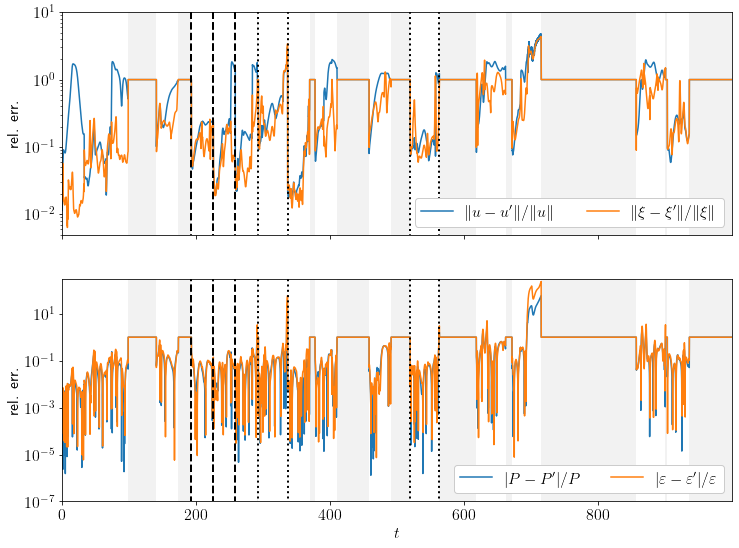

In [14]:
fig, axes = plt.subplots(2,1,figsize=(12,9),sharex=True)
ax = axes[0]
ax.plot(tt_sol, error, label="$\\| u - u'\\| / \\| u \\|$")
ax.plot(tt_sol, error_, label="$\\|\\xi - \\xi'  \\| / \\| \\xi \|$")
ax.legend(ncol=2, framealpha=1.0)
ax.set_ylim(5 * 1e-3, 1e1)        

ax = axes[1]
ax.plot(tt_sol, error_I, label="$ |P - P'| / P$")
ax.plot(tt_sol, error_D, label="$ |\\varepsilon - \\varepsilon'| / \\varepsilon$")
ax.set_ylim(1e-7, 3e2)        
ax.legend(ncol=2, framealpha=1.0)
ax.set_xlabel("$t$")

mark_episodes_1 = [4, 5]
mark_episodes_2 = [7, 11]

for ax in axes:

    ax.set_ylabel("rel. err.")
    ax.set_yscale("log")
    ax.set_xlim(0, tt_sol[-1])
#     ax.set_xlim(0, 600)

    times_skipped=0

    for i, it_episode in enumerate(it_episodes):
        try:
            if (it_episode[1] == it_episodes[i+1][0]):
                continue
            else:
                t_i = tt_sol[it_episode[1]]
                t_f = tt_sol[it_episodes[i + 1][0]]
                add_rectangle(ax, t_i, t_f)
                times_skipped += t_f - t_i
                
        except:
            t_i = tt_sol[it_episode[1]]
            t_f = tt_sol[-1]
            add_rectangle(ax, t_i, t_f)
            times_skipped += t_f - t_i

    for i in mark_episodes_1:
        t_i = tt_sol[it_episodes[i][0]]
        t_f = tt_sol[it_episodes[i][1]]

        ax.plot([t_i, t_i], [1e-8, 1e3], 'k--', lw=2.0)
        ax.plot([t_f, t_f], [1e-8, 1e3], 'k--', lw=2.0)

    for i in mark_episodes_2:
        t_i = tt_sol[it_episodes[i][0]]
        t_f = tt_sol[it_episodes[i][1]]
        print(t_i, t_f)
        
        ax.plot([t_i, t_i], [1e-8, 1e3], 'k:', lw=2.0)
        ax.plot([t_f, t_f], [1e-8, 1e3], 'k:', lw=2.0)
        

fig.savefig("../tex/fig/prediction_errors.png")

/tmp/ipykernel_100534/327642110.py:242: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[label].set_yticklabels(yticklabels)


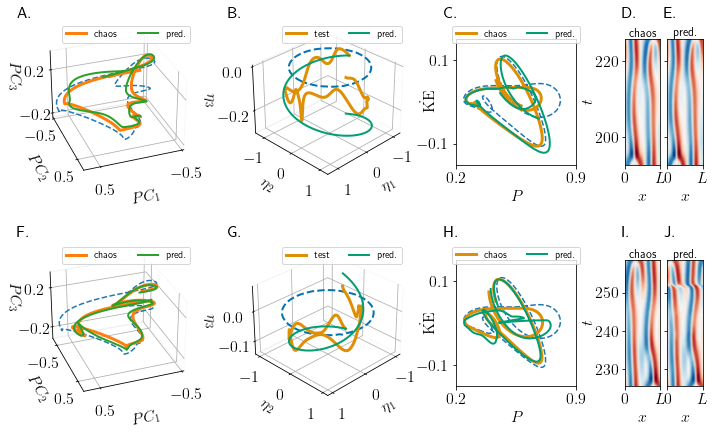

In [15]:
# Create layout
layout = [
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "U", "U", "U", "Z", "W", "W"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "V", "V", "V", "Z", "T", "T"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "V", "V", "V", "Z", "T", "T"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "P", "P", "P", "Z", "S", "S"],    
]
fig, axd = plt.subplot_mosaic(layout, figsize=(12,8))

# by default all axes are 2d, below is a hack to make A 3d:

for label in ['A', 'B', 'F', 'G']:
    specs = axd[label].get_subplotspec()
    axd[label].remove()
    axd[label] = fig.add_subplot(specs, projection='3d')
    ax = axd[label]

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.pane.fill = False


po = list(pos)[0]
pca = pos[po]['pca']
conjnet = pos[po]['conjnet']

torch_sol_po_ = torch.tensor(pos[po]['red_sol'])
latent_po = conjnet.encoder(torch_sol_po_).detach().numpy()
power_in_po = ks.power_in(pos[po]['sol'])
dissip_po = ks.dissipation(pos[po]['sol'])

i_episode = 4
i_i = it_episodes[i_episode][0]
i_f = it_episodes[i_episode][1]
t_i = tt_sol[i_i]
t_f = tt_sol[i_f]

sol_test = sol[i_i:i_f, :]
sol_test_ = sol_[i_i:i_f, :]
tt_test = tt_sol[i_i:i_f]

power_in_test = input_sol[i_i:i_f]
dissip_test = dissip_sol[i_i:i_f]

sol_pred = sol_pred_[i_i:i_f, :]
rec_sol_pred = sol_rec[i_i:i_f, :]
power_in_pred_episode = input_pred[i_i:i_f]
dissip_pred_episode = dissip_pred[i_i:i_f]

latent_test_episode = latent_sol[i_i:i_f, :] 
latent_pred_episode = latent_pred[i_i:i_f, :] 

sol_pred_pca = pca.transform(sol_pred)
sol_test_pca = pca.transform(sol_test_)

axd['A'].plot(pos[po]['po_pca'][:, 0], pos[po]['po_pca'][:,1], pos[po]['po_pca'][:,2], '--')
axd['A'].plot(sol_test_pca[:,0], sol_test_pca[:,1], sol_test_pca[:,2], lw=3.0, label='chaos')
axd['A'].plot(sol_pred_pca[:,0], sol_pred_pca[:,1], sol_test_pca[:,2], lw=2.0, label='pred.')

axd['B'].plot(
    latent_po[:, 0], latent_po[:, 1], latent_po[:, 2], 
    color=color_palette[0], lw=2.0, linestyle='--'
)
axd['B'].plot(
    latent_test_episode[:, 0], latent_test_episode[:, 1], latent_test_episode[:, 2], 
    color=color_palette[1], lw=3.0, label='test'
)
axd['B'].plot(
    latent_pred_episode[:, 0], latent_pred_episode[:, 1], latent_pred_episode[:, 2], 
    color=color_palette[2], lw=2.0, label='pred.'
)

axd['C'].plot(power_in_po, power_in_po - dissip_po, '--')
axd['C'].plot(power_in_test, power_in_test - dissip_test, color=color_palette[1], lw=3.0, label='chaos')
axd['C'].plot(power_in_pred_episode, power_in_pred_episode - dissip_pred_episode, color=color_palette[2], lw=2.0, label='pred.')

ks.plot_spacetime(sol_test, tt_test, ax=axd['D'], vmin=-0.095, vmax=0.095) 
ks.plot_spacetime(rec_sol_pred, tt_test, ax=axd['E'], vmin=-0.095, vmax=0.095) 


po = list(pos)[0]
pca = pos[po]['pca']
conjnet = pos[po]['conjnet']

torch_sol_po_ = torch.tensor(pos[po]['red_sol'])
latent_po = conjnet.encoder(torch_sol_po_).detach().numpy()
power_in_po = ks.power_in(pos[po]['sol'])
dissip_po = ks.dissipation(pos[po]['sol'])

i_episode = 5
i_i = it_episodes[i_episode][0]
i_f = it_episodes[i_episode][1]
t_i = tt_sol[i_i]
t_f = tt_sol[i_f]

sol_test = sol[i_i:i_f, :]
sol_test_ = sol_[i_i:i_f, :]
tt_test = tt_sol[i_i:i_f]

power_in_test = input_sol[i_i:i_f]
dissip_test = dissip_sol[i_i:i_f]

sol_pred = sol_pred_[i_i:i_f, :]
rec_sol_pred = sol_rec[i_i:i_f, :]
power_in_pred_episode = input_pred[i_i:i_f]
dissip_pred_episode = dissip_pred[i_i:i_f]

latent_test_episode = latent_sol[i_i:i_f, :] 
latent_pred_episode = latent_pred[i_i:i_f, :] 

sol_pred_pca = pca.transform(sol_pred)
sol_test_pca = pca.transform(sol_test_)

axd['F'].plot(pos[po]['po_pca'][:, 0], pos[po]['po_pca'][:,1], pos[po]['po_pca'][:,2], '--')
axd['F'].plot(sol_test_pca[:,0], sol_test_pca[:,1], sol_test_pca[:,2], lw=3.0, label='chaos')
axd['F'].plot(sol_pred_pca[:,0], sol_pred_pca[:,1], sol_test_pca[:,2], lw=2.0, label='pred.')

axd['G'].plot(
    latent_po[:, 0], latent_po[:, 1], latent_po[:, 2], 
    color=color_palette[0], lw=2.0, linestyle='--'
)
axd['G'].plot(
    latent_test_episode[:, 0], latent_test_episode[:, 1], latent_test_episode[:, 2], 
    color=color_palette[1], lw=3.0, label='test'
)
axd['G'].plot(
    latent_pred_episode[:, 0], latent_pred_episode[:, 1], latent_pred_episode[:, 2], 
    color=color_palette[2], lw=2.0, label='pred.'
)

axd['H'].plot(power_in_po, power_in_po - dissip_po, '--')
axd['H'].plot(power_in_test, power_in_test - dissip_test, color=color_palette[1], lw=3.0, label='chaos')
axd['H'].plot(power_in_pred_episode, power_in_pred_episode - dissip_pred_episode, color=color_palette[2], lw=2.0, label='pred.')

ks.plot_spacetime(sol_test, tt_test, ax=axd['I'], vmin=-0.095, vmax=0.095) 
ks.plot_spacetime(rec_sol_pred, tt_test, ax=axd['J'], vmin=-0.095, vmax=0.095) 

for ax in [axd['B'], axd['G']]:
    ax.set_xlabel("$\eta_1$")
    ax.set_ylabel("$\eta_2$")
    ax.set_zlabel("$\eta_3$       ")

for ax in [axd['D'], axd['E'], axd['I'], axd['J']]:
    ax.set_xticks([0, 22.0])
    ax.set_xticklabels(['$0$', '$L$  '])

# fig.tight_layout()

for label in ['U', 'V', 'X', 'Y', 'Z', 'W', 'S', 'P', 'T']:
    axd[label].set_visible(False)

for label in ['A', 'B', 'C', 'D', 'E']:
        
    ax = axd[label]
    label_x = ax.transAxes.transform([-0.1, 1]) # to display coordinates
    label_x = fig.transFigure.inverted().transform(label_x)[0] # display->fig.
    
    if label in ['A', 'B']:
        ax.text2D(label_x, 0.84, f"{label}.", transform=fig.transFigure)
    else:
        ax.text(label_x, 0.84, f"{label}.", transform=fig.transFigure)
        

for label in ['F', 'G', 'H', 'I', 'J']:
        
    ax = axd[label]
    label_x = ax.transAxes.transform([-0.1, 1]) # to display coordinates
    label_x = fig.transFigure.inverted().transform(label_x)[0] # display->fig.
    
    if label in ['F', 'G']:
        ax.text2D(label_x, 0.46, f"{label}.", transform=fig.transFigure)
    else:
        ax.text(label_x, 0.46, f"{label}.", transform=fig.transFigure)

        
for label in ['A', 'F']: 
    c_zoom = 0.9
    ax = axd[label]
    ax.view_init(30, 70)
    ax.set_xlim(
        ax.get_xlim()[0] * c_zoom, 
        ax.get_xlim()[1] * c_zoom
        )
    ax.set_ylim(
        ax.get_ylim()[0] * c_zoom, 
        ax.get_ylim()[1] * c_zoom
        )
    ax.set_zlim(
        ax.get_zlim()[0] * c_zoom, 
        ax.get_zlim()[1] * c_zoom
        )
    ax.set_zticks([-.2, .2])
    ax.set_xticks([-.5, .5])
    ax.set_yticks([-.5, .5])

    ax.set_xlabel("$PC_1$")
    ax.set_ylabel("$PC_2$")
    ax.set_zlabel("       $PC_3$")
    
for label in ['B', 'G']:
    axd[label].view_init(30,45)

for label in ['A', 'F']:
    axd[label].legend(fontsize=10, ncol = 2)

for label in ['B', 'G']:
    axd[label].legend(fontsize=10, loc=1, ncol = 2)
        
for label in ['C', 'H']:
    ax=axd[label]
    ax.legend(loc=9, fontsize=10, ncol=2, bbox_to_anchor=(0.5, 1.15))
    ax.set_xlim(0.2, 0.9)
    ax.set_ylim(-0.15, 0.15)
    ax.set_xticks([0.2, 0.9])
    ax.set_yticks([-0.1, 0.1])
#     ax.plot([0.2, 1.0], [0.2, 1.0], 'k-', lw=1.0, zorder=-5)
    
    ax.set_xlabel("$P$")
    ax.set_ylabel("$\dot{\mathrm{KE}}$", labelpad=-20)

axd['D'].set_ylabel('$t$',labelpad=0)
axd['I'].set_ylabel('$t$',labelpad=0)
axd['D'].set_xlabel('$x$')
axd['I'].set_xlabel('$x$')

axd['D'].set_title('chaos', fontsize=12, pad=-1)
axd['I'].set_title('chaos', fontsize=12, pad=-1)
axd['E'].set_title('pred.', fontsize=12, pad=-1)
axd['J'].set_title('pred.', fontsize=12, pad=-1)

for label in ['E', 'J']:
    axd[label].set_ylabel('')
    yticks = axd[label].get_yticks()
    yticklabels = []
    for tick in yticks:
        yticklabels.append('')
    axd[label].set_yticklabels(yticklabels)
    axd[label].set_xlabel("$x$")

fig.savefig("pred_po1.png", dpi=200)

In [16]:
# !/mpcdf/soft/SLE_15/packages/x86_64/imagemagick/7.1.1/bin/convert -trim pred_po1.png ../tex/fig/pred_po1.png

/tmp/ipykernel_97003/1582109122.py:241: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[label].set_yticklabels(yticklabels)


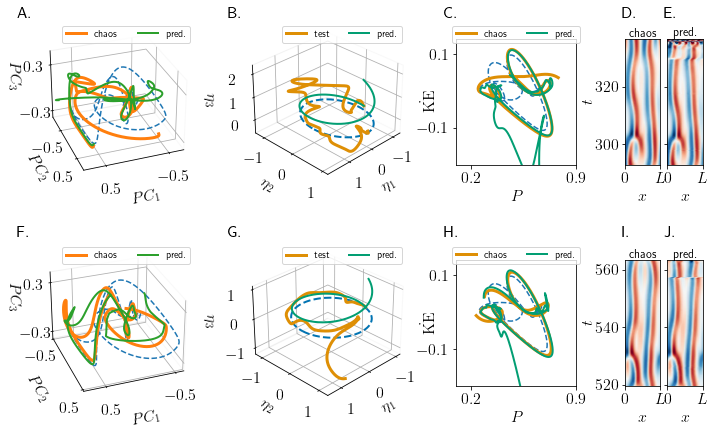

In [20]:
# Create layout
layout = [
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "U", "U", "U", "Z", "W", "W"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "C", "C", "C", "Z", "D", "E"],
    ["A", "A", "A", "A", "X", "B", "B", "B", "B", "Y", "V", "V", "V", "Z", "T", "T"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "V", "V", "V", "Z", "T", "T"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "H", "H", "H", "Z", "I", "J"],
    ["F", "F", "F", "F", "X", "G", "G", "G", "G", "Y", "P", "P", "P", "Z", "S", "S"],    
]
fig, axd = plt.subplot_mosaic(layout, figsize=(12,8))

# by default all axes are 2d, below is a hack to make A 3d:

for label in ['A', 'B', 'F', 'G']:
    specs = axd[label].get_subplotspec()
    axd[label].remove()
    axd[label] = fig.add_subplot(specs, projection='3d')
    ax = axd[label]

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.pane.fill = False


po = list(pos)[2]
pca = pos[po]['pca']
conjnet = pos[po]['conjnet']

torch_sol_po_ = torch.tensor(pos[po]['red_sol'])
latent_po = conjnet.encoder(torch_sol_po_).detach().numpy()
power_in_po = ks.power_in(pos[po]['sol'])
dissip_po = ks.dissipation(pos[po]['sol'])

i_episode = 7
i_i = it_episodes[i_episode][0]
i_f = it_episodes[i_episode][1]
t_i = tt_sol[i_i]
t_f = tt_sol[i_f]

sol_test = sol[i_i:i_f, :]
sol_test_ = sol_[i_i:i_f, :]
tt_test = tt_sol[i_i:i_f]

power_in_test = input_sol[i_i:i_f]
dissip_test = dissip_sol[i_i:i_f]

sol_pred = sol_pred_[i_i:i_f, :]
rec_sol_pred = sol_rec[i_i:i_f, :]
power_in_pred_episode = input_pred[i_i:i_f]
dissip_pred_episode = dissip_pred[i_i:i_f]

latent_test_episode = latent_sol[i_i:i_f, :] 
latent_pred_episode = latent_pred[i_i:i_f, :] 

sol_pred_pca = pca.transform(sol_pred)
sol_test_pca = pca.transform(sol_test_)

axd['A'].plot(pos[po]['po_pca'][:, 0], pos[po]['po_pca'][:,1], pos[po]['po_pca'][:,2], '--')
axd['A'].plot(sol_test_pca[:,0], sol_test_pca[:,1], sol_test_pca[:,2], lw=3.0, label='chaos')
axd['A'].plot(sol_pred_pca[:,0], sol_pred_pca[:,1], sol_test_pca[:,2], lw=2.0, label='pred.')

axd['B'].plot(
    latent_po[:, 0], latent_po[:, 1], latent_po[:, 2], 
    color=color_palette[0], lw=2.0, linestyle='--'
)
axd['B'].plot(
    latent_test_episode[:, 0], latent_test_episode[:, 1], latent_test_episode[:, 2], 
    color=color_palette[1], lw=3.0, label='test'
)
axd['B'].plot(
    latent_pred_episode[:, 0], latent_pred_episode[:, 1], latent_pred_episode[:, 2], 
    color=color_palette[2], lw=2.0, label='pred.'
)

axd['C'].plot(power_in_po, power_in_po - dissip_po, '--')
axd['C'].plot(power_in_test, power_in_test - dissip_test, color=color_palette[1], lw=3.0, label='chaos')
axd['C'].plot(power_in_pred_episode, power_in_pred_episode - dissip_pred_episode, color=color_palette[2], lw=2.0, label='pred.')

ks.plot_spacetime(sol_test, tt_test, ax=axd['D'], vmin=-0.095, vmax=0.095)
ks.plot_spacetime(rec_sol_pred, tt_test, ax=axd['E'], vmin=-0.095, vmax=0.095)

po = list(pos)[2]
pca = pos[po]['pca']
conjnet = pos[po]['conjnet']

torch_sol_po_ = torch.tensor(pos[po]['red_sol'])
latent_po = conjnet.encoder(torch_sol_po_).detach().numpy()
power_in_po = ks.power_in(pos[po]['sol'])
dissip_po = ks.dissipation(pos[po]['sol'])

i_episode = 11
i_i = it_episodes[i_episode][0]
i_f = it_episodes[i_episode][1]
t_i = tt_sol[i_i]
t_f = tt_sol[i_f]

sol_test = sol[i_i:i_f, :]
sol_test_ = sol_[i_i:i_f, :]
tt_test = tt_sol[i_i:i_f]

power_in_test = input_sol[i_i:i_f]
dissip_test = dissip_sol[i_i:i_f]

sol_pred = sol_pred_[i_i:i_f, :]
rec_sol_pred = sol_rec[i_i:i_f, :]
power_in_pred_episode = input_pred[i_i:i_f]
dissip_pred_episode = dissip_pred[i_i:i_f]

latent_test_episode = latent_sol[i_i:i_f, :] 
latent_pred_episode = latent_pred[i_i:i_f, :] 

sol_pred_pca = pca.transform(sol_pred)
sol_test_pca = pca.transform(sol_test_)

axd['F'].plot(pos[po]['po_pca'][:, 0], pos[po]['po_pca'][:,1], pos[po]['po_pca'][:,2], '--')
axd['F'].plot(sol_test_pca[:,0], sol_test_pca[:,1], sol_test_pca[:,2], lw=3.0, label='chaos')
axd['F'].plot(sol_pred_pca[:,0], sol_pred_pca[:,1], sol_test_pca[:,2], lw=2.0, label='pred.')

axd['G'].plot(
    latent_po[:, 0], latent_po[:, 1], latent_po[:, 2], 
    color=color_palette[0], lw=2.0, linestyle='--'
)
axd['G'].plot(
    latent_test_episode[:, 0], latent_test_episode[:, 1], latent_test_episode[:, 2], 
    color=color_palette[1], lw=3.0, label='test'
)
axd['G'].plot(
    latent_pred_episode[:, 0], latent_pred_episode[:, 1], latent_pred_episode[:, 2], 
    color=color_palette[2], lw=2.0, label='pred.'
)

axd['H'].plot(power_in_po, power_in_po - dissip_po, '--')
axd['H'].plot(power_in_test, power_in_test - dissip_test, color=color_palette[1], lw=3.0, label='chaos')
axd['H'].plot(power_in_pred_episode, power_in_pred_episode - dissip_pred_episode, color=color_palette[2], lw=2.0, label='pred.')

ks.plot_spacetime(sol_test, tt_test, ax=axd['I'], vmin=-0.095, vmax=0.095)
ks.plot_spacetime(rec_sol_pred, tt_test, ax=axd['J'], vmin=-0.095, vmax=0.095)

for ax in [axd['B'], axd['G']]:
    ax.set_xlabel("$\eta_1$")
    ax.set_ylabel("$\eta_2$")
    ax.set_zlabel("$\eta_3$       ")

for ax in [axd['D'], axd['E'], axd['I'], axd['J']]:
    ax.set_xticks([0, 22.0])
    ax.set_xticklabels(['$0$', '$L$  '])

# fig.tight_layout()

for label in ['U', 'V', 'X', 'Y', 'Z', 'W', 'S', 'P', 'T']:
    axd[label].set_visible(False)

for label in ['A', 'B', 'C', 'D', 'E']:
        
    ax = axd[label]
    label_x = ax.transAxes.transform([-0.1, 1]) # to display coordinates
    label_x = fig.transFigure.inverted().transform(label_x)[0] # display->fig.
    
    if label in ['A', 'B']:
        ax.text2D(label_x, 0.84, f"{label}.", transform=fig.transFigure)
    else:
        ax.text(label_x, 0.84, f"{label}.", transform=fig.transFigure)
        

for label in ['F', 'G', 'H', 'I', 'J']:
        
    ax = axd[label]
    label_x = ax.transAxes.transform([-0.1, 1]) # to display coordinates
    label_x = fig.transFigure.inverted().transform(label_x)[0] # display->fig.
    
    if label in ['F', 'G']:
        ax.text2D(label_x, 0.46, f"{label}.", transform=fig.transFigure)
    else:
        ax.text(label_x, 0.46, f"{label}.", transform=fig.transFigure)

        
for label in ['A', 'F']: 
    c_zoom = 0.9
    ax = axd[label]
    ax.view_init(30, 70)
    ax.set_xlim(
        ax.get_xlim()[0] * c_zoom, 
        ax.get_xlim()[1] * c_zoom
        )
    ax.set_ylim(
        ax.get_ylim()[0] * c_zoom, 
        ax.get_ylim()[1] * c_zoom
        )
    ax.set_zlim(
        ax.get_zlim()[0] * c_zoom, 
        ax.get_zlim()[1] * c_zoom
        )
    ax.set_zticks([-.3, .3])
    ax.set_xticks([-.5, .5])
    ax.set_yticks([-.5, .5])

    ax.set_xlabel("$PC_1$")
    ax.set_ylabel("$PC_2$")
    ax.set_zlabel("     $PC_3$")
    
for label in ['B', 'G']:
    axd[label].view_init(30,45)

for label in ['A', 'F']:
    axd[label].legend(fontsize=10, ncol = 2)

for label in ['B', 'G']:
    axd[label].legend(fontsize=10, loc=1, ncol = 2)
        
for label in ['C', 'H']:
    ax=axd[label]
    ax.legend(loc=9, fontsize=10, ncol=2, bbox_to_anchor=(0.5, 1.15))
    ax.set_xlim(0.1, 0.9)
    ax.set_ylim(-0.2, 0.14)
    ax.set_xticks([0.2, 0.9])
    ax.set_yticks([-0.1, 0.1])
#     ax.plot([0.2, 1.0], [0.2, 1.0], 'k-', lw=1.0, zorder=-5)
    
    ax.set_xlabel("$P$")
    ax.set_ylabel("$\dot{\mathrm{KE}}$", labelpad=-20)

axd['D'].set_ylabel('$t$',labelpad=0)
axd['I'].set_ylabel('$t$',labelpad=0)
axd['D'].set_xlabel('$x$')
axd['I'].set_xlabel('$x$')

axd['D'].set_title('chaos', fontsize=12, pad=-1)
axd['I'].set_title('chaos', fontsize=12, pad=-1)
axd['E'].set_title('pred.', fontsize=12, pad=-1)
axd['J'].set_title('pred.', fontsize=12, pad=-1)

for label in ['E', 'J']:
    axd[label].set_ylabel('')
    yticks = axd[label].get_yticks()
    yticklabels = []
    for tick in yticks:
        yticklabels.append('')
    axd[label].set_yticklabels(yticklabels)
    axd[label].set_xlabel("$x$")

fig.savefig("pred_po3.png", dpi=200)

In [21]:
!/mpcdf/soft/SLE_15/packages/x86_64/imagemagick/7.1.1/bin/convert -trim pred_po3.png ../tex/fig/pred_po3.png